#Neural Network for Fashion Mnist


#Problem Statement
In this assignment you need to implement a feedforward neural network and write the backpropagation code for training the network. We strongly recommend using numpy for all matrix/vector operations. You are not allowed to use any automatic differentiation packages. This network will be trained and tested using the Fashion-MNIST dataset. Specifically, given an input image (28 x 28 = 784 pixels) from the Fashion-MNIST dataset, the network will be trained to classify the image into 1 of 10 classes

######Required Imports for file

In [ ]:
import numpy as np
import math
import tensorflow as tf
from keras.datasets import fashion_mnist 
 
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder

In [ ]:
def plot_confusion_mtx(matrix,num_classes):

  plt.figure(figsize=(10,8))
  ax= plt.subplot()
  cmap=sns.light_palette("blue")
  sns.heatmap(matrix, annot=True, ax = ax,fmt=".3f"); 
  # labels, title and ticks
  ax.set_xlabel('Predicted labels');ax.set_ylabel('Actual labels');
  ax.set_title('Confusion Matrix');
  ax.xaxis.set_ticklabels([str(i) for i in range(num_classes)]); ax.yaxis.set_ticklabels([str(i) for i in range(num_classes)]);
  plt.show()

##Question 1 
Download the fashion-MNIST dataset and plot 1 sample image for each class as shown in the grid below. Use "from keras.datasets import fashion_mnist" for getting the fashion mnist dataset.

In [ ]:
(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()
labels=["T-shirt/top","Trouser","Pullover","Dress","Coat",
        "Sandal","Shirt","Sneaker","Bag","Ankle boot"]

4423680/4422102 [==============================] - 0s 0us/step


Installing and importing wandb library to use the functionalites of Wandb.ai

In [ ]:
!pip install wandb -qqq
import wandb
wandb.login()

     |████████████████████████████████| 2.0MB 15.7MB/s 
     |████████████████████████████████| 102kB 12.0MB/s 
     |████████████████████████████████| 133kB 59.3MB/s 
     |████████████████████████████████| 163kB 52.4MB/s 
     |████████████████████████████████| 71kB 11.0MB/s 


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
wandb.init(project='DeepLearning', entity='manideepladi')
def plot_images():
  plottedClass =  [False for i in range(10)] 
  images=[]
  classes=[]
  for i in range(100):
      if  plottedClass[Y_train[i]]==False:
        images.append(X_train[i])
        classes.append(labels[Y_train[i]])
        plottedClass[Y_train[i]]=True
        wandb.log({"Sample Images of all classes": [wandb.Image(img,caption=label) for img,label in zip(images,classes)]})
plot_images()

wandb: Currently logged in as: manideepladi (use `wandb login --relogin` to force relogin)


# Question 2 

Implement a feedforward neural network which takes images from the fashion-mnist data as input and outputs a probability distribution over the 10 classes.

Your code should be flexible so that it is easy to change the number of hidden layers and the number of neurons in each hidden layer.

We will check the code for implementation and ease of use.

#### Data Preprocessing
Reshaping dataset and generating one hot encoders along with

In [ ]:
#flatten the Xtrain and X_test
X_train=X_train.reshape((X_train.shape[0],X_train.shape[1]*X_train.shape[2]))
X_test=X_test.reshape((X_test.shape[0],X_test.shape[1]*X_test.shape[2]))

#create one hot encoding of the labels
Y_train_ohe=OneHotEncoder().fit_transform(Y_train.reshape(-1,1)).toarray()
Y_test_ohe=OneHotEncoder().fit_transform(Y_test.reshape(-1,1)).toarray()


#normalizing the train data and test data...
X_train = X_train/255
X_test = X_test/255

#### Keeping 10 percent of training data aside as validation data for hyperparameter search

In [ ]:
X_actualTrain,X_validationData,Y_actualTrain,Y_validationData=train_test_split(X_train,Y_train_ohe,test_size=0.2,stratify=Y_train_ohe)

#####Activation functions

In [ ]:
class Activation:

  def Sigmoid(self,x):
    return 1/(1+np.exp(-x))

  def Softmax(self,x):
    mx = np.max(x,axis=1).reshape(-1,1)
    num = np.exp(x-mx)
    denom = np.sum(num,axis = 1).reshape(-1,1)
    return num/denom

  def Relu(self,x):
    return np.maximum(0, x)

  def Tanh(self,x):
    numr = np.exp(x) - np.exp(-x)
    denom=np.exp(x) + np.exp(-x)
    return numr/denom

  def Derivative_Sigmoid(self,x):
    s=1/(1 + np.exp(-x))
    return s*(1-s)

  def Derivative_Relu(self,x):
    return x>=0

  def Derivative_Tanh(self,x):
    return 1-self.Tanh(x)**2


#### Code for different Loss functions

In [ ]:
#Returns the average Loss..
class Loss:
  def CategoricalCrossEntropy(self,ypred,y):
    class_idx = np.argmax(y,axis=1)
    cce_loss = 0
    for i in range(len(class_idx)):
      cce_loss+=(-1)*np.log2(ypred[i] [class_idx[i]])
    return cce_loss/len(ypred)
  
  def MSE(self,ypred,y):
    return np.sum((ypred - y)**2)/len(ypred)

#### Code for hidden Layers and output layer 
Feedforward neural network which takes images from the fashion-mnist data as input and outputs a probability distribution over the 10 classes 

In [ ]:
class Layer:

  def __init__(self,num_inputs,num_neurons,activation,loss,optimizer,layerInitialization):
    
    self.num_inputs=num_inputs ;self.num_neurons=num_neurons ;self.activation=activation ;self.optimizer=optimizer ;self.loss=loss
    self.aL=0 ; self.hL=0 ; self.del_h=0 ;self.del_a=0 ;self.delW=0 ;self.delb=0 ;self.prev_Uw=0 ;self.prev_Ub=0
    self.prev_Vw=0 ;self.prev_Vb=0 ;self.prev_Mw=0 ;self.prev_Mb=0

    if layerInitialization=="random":
      self.W=np.random.randn(self.num_neurons,self.num_inputs) ;self.b=np.random.randn(self.num_neurons,)
    elif layerInitialization=="Xavier":
      initializer = tf.keras.initializers.GlorotNormal() ;self.W=initializer((self.num_neurons,self.num_inputs)).numpy() ;self.b=initializer((self.num_neurons,)).numpy()
    
  #Given input from the previous layer as h_L_1 get the preactivation(aL) and postactivation(hL)..  
  def Forward(self,h_L_1):
    self.aL = np.dot(h_L_1,(self.W).T)+self.b

    if self.activation=='ReLU':
      self.hL = Activation().Relu(self.aL)
    elif self.activation=='tanh':
      self.hL = Activation().Tanh(self.aL)
    elif self.activation=='Softmax':
      self.hL = Activation().Softmax(self.aL)
    elif self.activation == 'sigmoid':
      self.hL = Activation().Sigmoid(self.aL)
    else:
      raise Exception("choose a valid activation")
    
    return

  #Given Y_hat and Y calculate the gradients for diff Layers..
  def get_gradients(self,isoplayer,Y_hat,Y,prev_hL,nextW,next_del_a):

      #If it is the output layer...
      if isoplayer == 1:
        if self.loss=='cce':
          self.del_a = Y_hat-Y
        
        elif self.loss == 'squarederror':
          bs = len(Y)
          num_cls = len(Y[0])
          DelA=[]
          for j in range(bs):
            del_aj=[]
            init = 2*(Y_hat[j] - Y[j])*(Y_hat[j])
            for i in range(num_cls):
              ohe_i = np.zeros(num_cls,)
              ohe_i[i] = 1
              pd_aji=ohe_i - Y_hat[j][i]
              pd_aji *= init
              del_aj.append(np.sum(pd_aji,axis=0))
            DelA.append(del_aj)

          self.del_a = np.array(DelA)
        else:
          raise Exception("!!!  ")

      #if it is not the output layer..
      else:
        self.del_h = np.dot(next_del_a , nextW)
        if self.activation=='ReLU':
          self.del_a=(self.del_h)*(Activation().Derivative_Relu(self.aL))
        elif self.activation=='tanh':
          self.del_a=(self.del_h)*(Activation().Derivative_Tanh(self.aL))
        elif self.activation == 'sigmoid':
          self.del_a=(self.del_h)*(Activation().Derivative_Sigmoid(self.aL))

      self.delW = np.dot(self.del_a.T,prev_hL)/len(Y)
      self.delb = np.sum(self.del_a,axis=0)/len(Y)
      return

Input Layer code

In [ ]:
class IpLayer:

  def __init__(self,num_neurons):
    self.num_neurons=num_neurons
    self.hL=0

  def Forward(self,x):
    self.hL=x

# Question 3

Implement the backpropagation algorithm with support for the following optimisation functions 

- sgd
- momentum based gradient descent
- nesterov accelerated gradient descent
- rmsprop
- adam
- nadam

(12 marks for the backpropagation framework and 2 marks for each of the optimisation algorithms above)

We will check the code for implementation and ease of use (e.g., how easy it is to add a new optimisation algorithm such as Eve). Note that the code should be flexible enough to work with different batch sizes.

### Code for Neural Network architecture
It supports feed forward and back propogation with support for the various optimization functions

In [ ]:
class NN:

  def __init__(self,input_shape,num_hlayers,neurons,hiddenLayerActivation,outputActivation,loss,optimizer,learningrate,batch_size,epochs,layerInitialization,weightDecay,output_shape):

    self.input_shape=input_shape ;self.output_shape=output_shape ;self.num_hlayers=num_hlayers ;self.neurons=neurons ;self.HLAc=hiddenLayerActivation
    self.OPAc=outputActivation ;self.optimizer=optimizer ;self.batch_size=batch_size ;self.epochs=epochs ; self.layer_init=layerInitialization
    self.Layers=[] ;self.eta=learningrate ;self.weightDecay=weightDecay ;self.learningrate=learningrate
    self.gamma=0.9 ;self.beta=0.8 ;self.epsilon=1e-5 ; self.beta1=0.9 ;self.beta2=0.999 ;self.Y_hat=0 ; self.loss=loss
    
    #store the Layers in self.Layers[]..

    self.Layers.append(IpLayer(self.input_shape))
    #hidden layers..
    for layer in range(1,self.num_hlayers+2):
      ip_shape=self.Layers[layer-1].num_neurons
      #output layer...
      if layer==self.num_hlayers+1:
         self.Layers.append(Layer(ip_shape,self.output_shape,self.OPAc,self.loss,self.optimizer,layerInitialization))
      else:
        self.Layers.append(Layer(ip_shape,self.neurons[layer-1],self.HLAc,self.loss,self.optimizer,layerInitialization))

  #given a batch X feed it forward in the network to get Y_hat..
  def Feed_Forward(self,X):
    self.Y_hat=[]
    if self.optimizer=='nesterov' or self.optimizer=='nadam':
      #Go to lookaheads(Wla,bla) and get the loss there..
      for i in range(1,self.num_hlayers+2):
        self.Layers[i].W = self.Layers[i].W - self.gamma * self.Layers[i].prev_Uw
        self.Layers[i].b = self.Layers[i].b - self.gamma * self.Layers[i].prev_Ub

    #get the data in input layer...
    self.Layers[0].Forward(X)
    for j in range(1,self.num_hlayers+2):
      h_L_1=self.Layers[j-1].hL
      self.Layers[j].Forward(h_L_1)
    self.Y_hat = self.Layers[self.num_hlayers+1].hL
    return
  
  #get gradients for each layer...
  def Back_Propogation(self,Y):
    for i in range(self.num_hlayers+1,0,-1):
      prev_hL = self.Layers[i-1].hL
      if i == self.num_hlayers+1:
        self.Layers[i].get_gradients(1,self.Y_hat,Y,prev_hL,0,0)
      else:
        next_W = self.Layers[i+1].W
        next_del_a = self.Layers[i+1].del_a
        self.Layers[i].get_gradients(0,self.Y_hat,Y,prev_hL,next_W,next_del_a)
    return

  #Update W,b for each layer w.r.t. the optimizer used...
  def Update_Params(self,iteration):

    for i in range(1,self.num_hlayers+2):
      if self.optimizer == 'sgd':
        self.Layers[i].W = (1-self.weightDecay*(self.eta))*self.Layers[i].W - (self.eta)*(self.Layers[i].delW)
        self.Layers[i].b = (1-self.weightDecay*(self.eta))*self.Layers[i].b - (self.eta)*(self.Layers[i].delb)
      elif self.optimizer == 'momentum' or self.optimizer == 'nesterov':
        #get momentum..
        Uw_t = (self.gamma) * (self.Layers[i].prev_Uw) + (self.eta) * (self.Layers[i].delW)
        Ub_t = self.gamma * self.Layers[i].prev_Ub + (self.eta) * (self.Layers[i].delb)
        #update the parameters..
        self.Layers[i].W = (1-self.weightDecay*(self.eta))*self.Layers[i].W - Uw_t
        self.Layers[i].b = (1-self.weightDecay*(self.eta))*self.Layers[i].b - Ub_t
        #update the moments..
        self.Layers[i].prev_Uw = Uw_t
        self.Layers[i].prev_Ub = Ub_t

      elif self.optimizer == 'rmsprop':
        #get vt's and update history..
        self.Layers[i].prev_Vw = (self.beta)*(self.Layers[i].prev_Vw) + (1-self.beta)*(self.Layers[i].delW)**2   
        self.Layers[i].prev_Vb = (self.beta)*(self.Layers[i].prev_Vb) + (1-self.beta)*(self.Layers[i].delb)**2.   
        #update the parameters..
        self.Layers[i].W = (1-self.weightDecay*(self.eta))*self.Layers[i].W - (self.eta)*((self.Layers[i].delW)/np.sqrt(self.Layers[i].prev_Vw+self.epsilon)) 
        self.Layers[i].b = (1-self.weightDecay*(self.eta))*self.Layers[i].b - (self.eta)*((self.Layers[i].delb)/np.sqrt(self.Layers[i].prev_Vb+self.epsilon)) 

      elif self.optimizer == 'adam' or self.optimizer == 'nadam':
        #update previous history..
        self.Layers[i].prev_Mw = self.beta1 * self.Layers[i].prev_Mw + (1-self.beta1) * (self.Layers[i].delW)
        self.Layers[i].prev_Mb = self.beta1 * self.Layers[i].prev_Mb + (1-self.beta1) * (self.Layers[i].delb)
        #2>> Get the learning rate update: Vw=beta2*(V_w[t-1])+(1-beta2)*(delW)**2
        self.Layers[i].prev_Vw = self.beta2 * self.Layers[i].prev_Vw + (1-self.beta2) * (self.Layers[i].delW)**2
        self.Layers[i].prev_Vb = self.beta2 * self.Layers[i].prev_Vb + (1-self.beta2) * (self.Layers[i].delb)**2
        #3>> Get m^W,V^W and m^b and V^b
        m_w_hat = self.Layers[i].prev_Mw/(1 - math.pow(self.beta1,iteration+1))
        m_b_hat = self.Layers[i].prev_Mb/(1 - math.pow(self.beta1,iteration+1))
        v_w_hat = self.Layers[i].prev_Vw/(1 - math.pow(self.beta2,iteration+1))
        v_b_hat = self.Layers[i].prev_Vb/(1 - math.pow(self.beta2,iteration+1))
        #4>> update W ,b for each layer..
        self.Layers[i].W = (1-self.weightDecay*(self.eta))*self.Layers[i].W - (self.eta)*(m_w_hat/np.sqrt(v_w_hat+self.epsilon))
        self.Layers[i].b = (1-self.weightDecay*(self.eta))*self.Layers[i].b - (self.eta)*(m_b_hat/np.sqrt(v_b_hat+self.epsilon))
      else:
        raise Exception("Invalid optimizer!!!!!")
    
    return

  #Given X get the probability output for X..
  def Final_Prediction(self,X):
    pred_whole=[]
    self.Layers[0].Forward(X)
    for j in range(1,self.num_hlayers+2):
      h_L_1=self.Layers[j-1].hL
      self.Layers[j].Forward(h_L_1)
    
    return  self.Layers[self.num_hlayers+1].hL
 

## Code for supporting different batch sizes of optimization algorithms

In [ ]:
def MINI_BATCH(NN,X,Y):
  loss_epoch=[]
  n=X.shape[0]
  for i in range(NN.epochs):
    itr=0
    sidx = 0
    #pass data by batches and update the W,b..
    while sidx+NN.batch_size <= n:
      NN.Feed_Forward(X[sidx : sidx+NN.batch_size])
      NN.Back_Propogation(Y[sidx : sidx+NN.batch_size])
      NN.Update_Params(itr)
      itr+=1
      sidx+=NN.batch_size
      
    #pass the remining data.
    if sidx!=n:
      NN.Feed_Forward(X[sidx : n])
      NN.Back_Propogation(Y[sidx : n])
      NN.Update_Params(itr)
      NN.Reset_Gradients()

  return NN.Final_Prediction(X)


**Run the Model for a particular set of parameters**

In [ ]:
def Run_Model(params,X_tr,Y_tr,X_cv,Y_cv,X_test,Y_test):
  
  NN2 = NN(input_shape=params['input_shape'],num_hlayers=params['num_hlayers'],neurons=params['neurons'],hiddenLayerActivation=params['HLAc'],\
           outputActivation=params['OPAc'],loss=params['loss'],optimizer=params['optimizer'],\
           learningrate=params['eta'],batch_size=params['batch_size'],epochs=params['epochs'],layerInitialization=params['layer_init'],\
           weightDecay=params['weightDecay'],output_shape=params['output_shape'])

  pred =MINI_BATCH(NN2,X_tr,Y_tr)
  print("train accuracy : ",np.sum(np.argmax(pred,axis=1)==np.argmax(Y_tr,axis=1))/len(Y_tr))

  predcv = NN2.Final_Prediction(X_cv)
  print("cv accuracy : ",np.sum(np.argmax(predcv,axis=1)==np.argmax(Y_cv,axis=1))/len(Y_cv))


  predtest =NN2.Final_Prediction(X_test)
  print("TEST accuracy : ",np.sum(np.argmax(predtest,axis=1)==np.argmax(Y_test_ohe,axis=1))/len(Y_test_ohe))

  return

In [ ]:
params={'input_shape':784,        #input shape of your data.
        'num_hlayers':3,          #number of hidden layers.
        'neurons':[32,32,32],     #number of neurons in each HL.
        'HLAc':'ReLU',            #Try with one of values ['sigmoid','tanh','ReLU']
        'OPAc':'Softmax',         #output activation
        'loss':'squarederror',    #try one of ['squarederror','cce']
        'optimizer':'momentum',   #try with one of ['sgd' ,'momentum' , 'nesterov' , 'rmsprop' , 'nadam' ]
        'eta':1e-3,               #learning rate       
        'batch_size':64,          #batch_size
        'epochs' :2,              #number of epochs
        'layer_init':'Xavier',    #try with 'random'
        'weightDecay':0.0005,   
        'output_shape':10}

Run_Model(params,X_actualTrain,Y_actualTrain,X_validationData,Y_validationData,X_test,Y_test)

train accuracy :  0.7199375
cv accuracy :  0.7204166666666667
TEST accuracy :  0.7124


# Question 4

Use the sweep functionality provided by wandb to find the best values for the hyperparameters listed below. Use the standard train/test split of fashion_mnist (use (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()).  Keep 10% of the training data aside as validation data for this hyperparameter search. Here are some suggestions for different values to try for hyperparameters. As you can quickly see that this leads to an exponential number of combinations. You will have to think about strategies to do this hyperparameter search efficiently. Check out the options provided by wandb.sweep and write down what strategy you chose and why.

- number of epochs: 5, 10
- number of hidden layers:  3, 4, 5
- size of every hidden layer:  32, 64, 128
- weight decay (L2 regularisation): 0, 0.0005,  0.5
- learning rate: 1e-3, 1 e-4 
- optimizer:  sgd, momentum, nesterov, rmsprop, adam, nadam
- batch size: 16, 32, 64
- weight initialisation: random, Xavier
- activation functions: sigmoid, tanh, ReLU

wandb will automatically generate the following plots. Paste these plots below using the "Add Panel to Report" feature. Make sure you use meaningful names for each sweep (e.g. hl_3_bs_16_ac_tanh to indicate that there were 3 hidden layers, batch size was 16 and activation function was ReLU) instead of using the default names (whole-sweep, kind-sweep) given by wandb.

### Sweep using wandb 

Sweep functionality will automate hyperparameter optimization and explore the space of possible models. Below is the sweep config file which uses **Bayesian Optimization** uses a gaussian process to model the function and then chooses parameters to optimize probability of improvement. This strategy requires a metric key to be specified. The metric we used here is to maximize accuracy as it is our primary goal.

In [ ]:
sweep_config = {
  "name": "HyperparameterSweep",
  "method": "bayes",
  "metric": {
      'name': 'accuracy',
      'goal': 'maximize'   
    },
  "parameters": {
        "optimizer": {
            "values": ['sgd','momentum','nesterov','rmsprop','adam','nadam']
        },
        "noOfNeurons":{
            "values":[32, 64]
        },
        "num_hlayers":{
            "values":[1,2,3]
        },
        "hiddenLayerActivation":{
            "values":['sigmoid','ReLU','tanh']
        },
        "outputActivation":{
            "values":['Softmax']
        },
        "learningrate":{
            "values":[1e-3,1e-4]
        },
        "layerInitialization":{
            "values":['random','Xavier']
        },
        "epochs":{
            "values":[5,10,20]
        },
        "weightDecay":{
            "values":[0,0.0005, 0.005]
        },
        "batch_size":{
            "values":[16,32,64]
        }

    }
}

sweep_id = wandb.sweep(sweep_config, project='DeepLearning', entity='manideepladi')

Create sweep with ID: m11vanks
Sweep URL: https://wandb.ai/manideepladi/DeepLearning/sweeps/m11vanks


### Code for training our model for various hyperparameters

In [ ]:
def train():
  run = wandb.init()
  

  configuration=run.config
  neurons=[]
  for i in range(configuration.num_hlayers):
    neurons.append(configuration.noOfNeurons)
  print(neurons)

  NN1 = NN(input_shape=784,num_hlayers=configuration.num_hlayers,neurons=neurons,hiddenLayerActivation=configuration.hiddenLayerActivation,\
           outputActivation=configuration.outputActivation,loss='cce',optimizer=configuration.optimizer,\
           learningrate=configuration.learningrate,batch_size=configuration.batch_size,epochs=configuration.epochs,\
           layerInitialization=configuration.layerInitialization,weightDecay=configuration.weightDecay,output_shape=10)


  pred =MINI_BATCH(NN1,X_actualTrain,Y_actualTrain)
  
  wandb.log({"Train accuracy": np.sum(np.argmax(pred,axis=1)==np.argmax(Y_actualTrain,axis=1))/len(Y_actualTrain)})


  predtest=NN1.Final_Prediction(X_validationData)
  
  wandb.log({"Test accuracy": np.sum(np.argmax(predtest,axis=1)==np.argmax(Y_validationData,axis=1))/len(Y_validationData)})

#train()
sweep_id="bm9asdx4"
wandb.agent(sweep_id=sweep_id, function=train)

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: palbzmpn with config:
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hiddenLayerActivation: Relu
wandb: 	layerInitialization: Random
wandb: 	learningrate: 0.001
wandb: 	noOfNeurons: 64
wandb: 	num_hlayers: 3
wandb: 	optimizer: Simple_GD
wandb: 	outputActivation: Softmax
wandb: 	weightDecay: 0


[64, 64, 64]


Train accuracy,0.58467
_runtime,18
_timestamp,1615680703
_step,1
Test accuracy,0.57417


Train accuracy,▁
_runtime,▁▁
_timestamp,▁▁
_step,▁█
Test accuracy,▁


wandb: Agent Starting Run: o7u2jf9m with config:
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hiddenLayerActivation: Sigmoid
wandb: 	layerInitialization: Random
wandb: 	learningrate: 0.001
wandb: 	noOfNeurons: 64
wandb: 	num_hlayers: 2
wandb: 	optimizer: Moment_Based
wandb: 	outputActivation: Softmax
wandb: 	weightDecay: 0.0005


[64, 64]


Train accuracy,0.74829
_runtime,29
_timestamp,1615680742
_step,1
Test accuracy,0.74583


Train accuracy,▁
_runtime,▁▁
_timestamp,▁▁
_step,▁█
Test accuracy,▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: i7ti094n with config:
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	hiddenLayerActivation: Tanh
wandb: 	layerInitialization: Xavier
wandb: 	learningrate: 0.0001
wandb: 	noOfNeurons: 64
wandb: 	num_hlayers: 3
wandb: 	optimizer: Simple_GD
wandb: 	outputActivation: Softmax
wandb: 	weightDecay: 0


[64, 64, 64]


Train accuracy,0.69108
_runtime,82
_timestamp,1615680849
_step,1
Test accuracy,0.68908


Train accuracy,▁
_runtime,▁▁
_timestamp,▁▁
_step,▁█
Test accuracy,▁


wandb: Agent Starting Run: twk68rb0 with config:
wandb: 	batch_size: 16
wandb: 	epochs: 20
wandb: 	hiddenLayerActivation: Relu
wandb: 	layerInitialization: Xavier
wandb: 	learningrate: 0.001
wandb: 	noOfNeurons: 64
wandb: 	num_hlayers: 3
wandb: 	optimizer: Simple_GD
wandb: 	outputActivation: Softmax
wandb: 	weightDecay: 0


[64, 64, 64]


Train accuracy,0.86017
_runtime,81
_timestamp,1615680937
_step,1
Test accuracy,0.85392


Train accuracy,▁
_runtime,▁▁
_timestamp,▁▁
_step,▁█
Test accuracy,▁


wandb: Agent Starting Run: ofzcyy3s with config:
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hiddenLayerActivation: Tanh
wandb: 	layerInitialization: Xavier
wandb: 	learningrate: 0.001
wandb: 	noOfNeurons: 32
wandb: 	num_hlayers: 1
wandb: 	optimizer: Nadam
wandb: 	outputActivation: Softmax
wandb: 	weightDecay: 0.0005


[32]


Train accuracy,0.88629
_runtime,39
_timestamp,1615680984
_step,1
Test accuracy,0.86758


Train accuracy,▁
_runtime,▁▁
_timestamp,▁▁
_step,▁█
Test accuracy,▁


wandb: Agent Starting Run: jf5kl484 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	hiddenLayerActivation: Relu
wandb: 	layerInitialization: Xavier
wandb: 	learningrate: 0.001
wandb: 	noOfNeurons: 64
wandb: 	num_hlayers: 3
wandb: 	optimizer: Adam
wandb: 	outputActivation: Softmax
wandb: 	weightDecay: 0.0005


[64, 64, 64]


Train accuracy,0.89242
_runtime,97
_timestamp,1615681090
_step,1
Test accuracy,0.86633


Train accuracy,▁
_runtime,▁▁
_timestamp,▁▁
_step,▁█
Test accuracy,▁


wandb: Agent Starting Run: yjiw5v93 with config:
wandb: 	batch_size: 16
wandb: 	epochs: 20
wandb: 	hiddenLayerActivation: Sigmoid
wandb: 	layerInitialization: Xavier
wandb: 	learningrate: 0.0001
wandb: 	noOfNeurons: 32
wandb: 	num_hlayers: 3
wandb: 	optimizer: Simple_GD
wandb: 	outputActivation: Softmax
wandb: 	weightDecay: 0.005


[32, 32, 32]


Train accuracy,0.296
_runtime,57
_timestamp,1615681156
_step,1
Test accuracy,0.29233


Train accuracy,▁
_runtime,▁▁
_timestamp,▁▁
_step,▁█
Test accuracy,▁


wandb: Agent Starting Run: fx6ptiro with config:
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hiddenLayerActivation: Relu
wandb: 	layerInitialization: Random
wandb: 	learningrate: 0.001
wandb: 	noOfNeurons: 32
wandb: 	num_hlayers: 3
wandb: 	optimizer: Nadam
wandb: 	outputActivation: Softmax
wandb: 	weightDecay: 0.005


[32, 32, 32]


Train accuracy,0.73375
_runtime,16
_timestamp,1615681181
_step,1
Test accuracy,0.72833


Train accuracy,▁
_runtime,▁█
_timestamp,▁█
_step,▁█
Test accuracy,▁


wandb: Agent Starting Run: kioi7ner with config:
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hiddenLayerActivation: Sigmoid
wandb: 	layerInitialization: Random
wandb: 	learningrate: 0.001
wandb: 	noOfNeurons: 64
wandb: 	num_hlayers: 1
wandb: 	optimizer: Simple_GD
wandb: 	outputActivation: Softmax
wandb: 	weightDecay: 0.0005


[64]


Train accuracy,0.64075
_runtime,34
_timestamp,1615681223
_step,1
Test accuracy,0.63858


Train accuracy,▁
_runtime,▁▁
_timestamp,▁▁
_step,▁█
Test accuracy,▁


wandb: Agent Starting Run: y4q0f9p1 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hiddenLayerActivation: Relu
wandb: 	layerInitialization: Xavier
wandb: 	learningrate: 0.0001
wandb: 	noOfNeurons: 32
wandb: 	num_hlayers: 2
wandb: 	optimizer: Moment_Based
wandb: 	outputActivation: Softmax
wandb: 	weightDecay: 0


[32, 32]


Train accuracy,0.80171
_runtime,16
_timestamp,1615681248
_step,1
Test accuracy,0.80117


Train accuracy,▁
_runtime,▁▁
_timestamp,▁▁
_step,▁█
Test accuracy,▁


wandb: Agent Starting Run: tkyynder with config:
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hiddenLayerActivation: Sigmoid
wandb: 	layerInitialization: Xavier
wandb: 	learningrate: 0.001
wandb: 	noOfNeurons: 32
wandb: 	num_hlayers: 3
wandb: 	optimizer: Simple_GD
wandb: 	outputActivation: Softmax
wandb: 	weightDecay: 0.0005


[32, 32, 32]


Train accuracy,0.1834
_runtime,9
_timestamp,1615681265
_step,1
Test accuracy,0.18325


Train accuracy,▁
_runtime,▁▁
_timestamp,▁▁
_step,▁█
Test accuracy,▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xrdq7la3 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	hiddenLayerActivation: Sigmoid
wandb: 	layerInitialization: Random
wandb: 	learningrate: 0.0001
wandb: 	noOfNeurons: 32
wandb: 	num_hlayers: 2
wandb: 	optimizer: RMSProp
wandb: 	outputActivation: Softmax
wandb: 	weightDecay: 0


[32, 32]


Train accuracy,0.75385
_runtime,28
_timestamp,1615681309
_step,1
Test accuracy,0.74683


Train accuracy,▁
_runtime,▁▁
_timestamp,▁▁
_step,▁█
Test accuracy,▁


wandb: Agent Starting Run: nde0ld36 with config:
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hiddenLayerActivation: Relu
wandb: 	layerInitialization: Xavier
wandb: 	learningrate: 0.001
wandb: 	noOfNeurons: 64
wandb: 	num_hlayers: 1
wandb: 	optimizer: Nadam
wandb: 	outputActivation: Softmax
wandb: 	weightDecay: 0.0005


[64]


Train accuracy,0.8895
_runtime,41
_timestamp,1615681358
_step,1
Test accuracy,0.87792


Train accuracy,▁
_runtime,▁▁
_timestamp,▁▁
_step,▁█
Test accuracy,▁


wandb: Agent Starting Run: feuov5fk with config:
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	hiddenLayerActivation: Tanh
wandb: 	layerInitialization: Random
wandb: 	learningrate: 0.0001
wandb: 	noOfNeurons: 64
wandb: 	num_hlayers: 3
wandb: 	optimizer: Moment_Based
wandb: 	outputActivation: Softmax
wandb: 	weightDecay: 0.0005


[64, 64, 64]


### Question 7 (10 Marks)
For the best model identified above, report the accuracy on the test set of fashion_mnist and plot the confusion matrix as shown below. More marks for creativity (less marks for producing the plot shown below as it is)



Below are the top 4 accuracy on validation dataset

train accuracy :  0.902
cv accuracy :  0.88
TEST accuracy :  0.8713


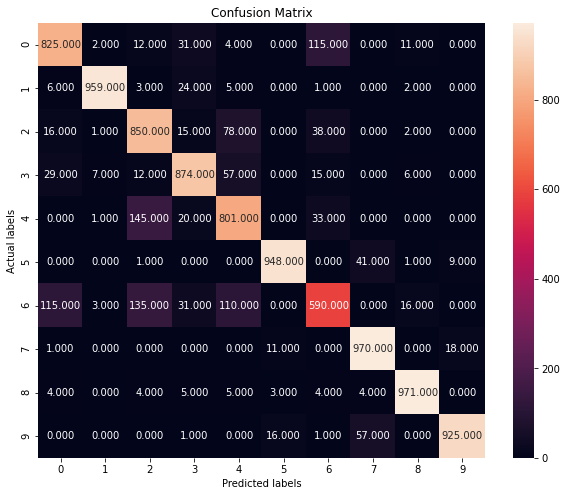

In [ ]:
wandb.init(project='DeepLearning', entity='manideepladi')
NN2 = NN(input_shape=784,num_hlayers=4,neurons=[64, 64 ,64,64],hiddenLayerActivation='ReLU',outputActivation='Softmax',loss='cce',optimizer='adam',\
           learningrate=0.001,batch_size=16,epochs=10,layerInitialization='Xavier',weightDecay=0,output_shape=10)

pred =MINI_BATCH(NN2,X_actualTrain,Y_actualTrain)
print("train accuracy : ",np.sum(np.argmax(pred,axis=1)==np.argmax(Y_actualTrain,axis=1))/len(Y_actualTrain))

predcv = NN2.Final_Prediction(X_validationData)
print("cv accuracy : ",np.sum(np.argmax(predcv,axis=1)==np.argmax(Y_validationData,axis=1))/len(Y_validationData))


predtest =NN2.Final_Prediction(X_test)
print("TEST accuracy : ",np.sum(np.argmax(predtest,axis=1)==np.argmax(Y_test_ohe,axis=1))/len(Y_test_ohe))

cf2 = confusion_matrix(y_true = np.argmax(Y_test_ohe,axis=1),y_pred = np.argmax(predtest , axis=1))
plot_confusion_mtx(cf2,10)
wandb.log({"conf_mat" : wandb.plot.confusion_matrix(probs=None,
                        y_true=np.argmax(Y_test_ohe,axis=1), preds=np.argmax(predtest , axis=1),
                        class_names= labels)})

wandb: Currently logged in as: manideepladi (use `wandb login --relogin` to force relogin)


train accuracy :  0.9042083333333333
cv accuracy :  0.8861666666666667
TEST accuracy :  0.874


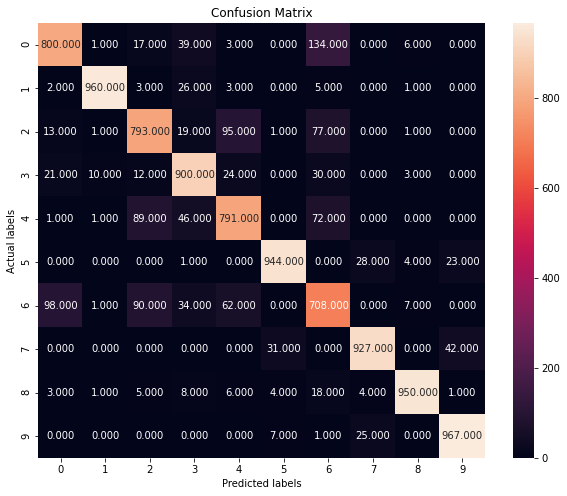

In [ ]:
import wandb
wandb.init(project='DeepLearning', entity='manideepladi')
NN3 = NN(input_shape=784,num_hlayers=2,neurons=[64, 64 ],hiddenLayerActivation='Tanh',outputActivation='Softmax',loss='cce'optimizer='momentum',\
           learningrate=0.001,batch_size=16,epochs=20,layerInitialization='Xavier',weightDecay=0.0005,output_shape=10)

pred =MINI_BATCH(NN3,X_actualTrain,Y_actualTrain)
print("train accuracy : ",np.sum(np.argmax(pred,axis=1)==np.argmax(Y_actualTrain,axis=1))/len(Y_actualTrain))

predcv = NN3.Final_Prediction(X_validationData)
print("cv accuracy : ",np.sum(np.argmax(predcv,axis=1)==np.argmax(Y_validationData,axis=1))/len(Y_validationData))

predtest =NN3.Final_Prediction(X_test)
print("TEST accuracy : ",np.sum(np.argmax(predtest,axis=1)==np.argmax(Y_test_ohe,axis=1))/len(Y_test_ohe))

cf3 = confusion_matrix(y_true = np.argmax(Y_test_ohe,axis=1),y_pred = np.argmax(predtest , axis=1))
plot_confusion_mtx(cf3,10)
wandb.log({"conf_mat" : wandb.plot.confusion_matrix(probs=None,
                        y_true=np.argmax(Y_test_ohe,axis=1), preds=np.argmax(predtest , axis=1),
                        class_names= labels)})

train accuracy :  0.91175
cv accuracy :  0.8838333333333334
TEST accuracy :  0.8704


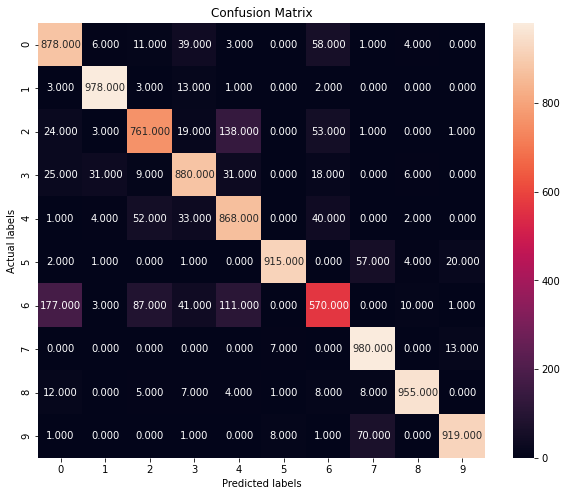

In [ ]:
NN4 = NN(input_shape=784,num_hlayers=1,neurons=[64],hiddenLayerActivation='Relu',outputActivation='Softmax',loss='cce',optimizer='nadam',\
           learningrate=0.001,batch_size=16,epochs=20,layerInitialization='Xavier',weightDecay=0.0005,output_shape=10)

pred =MINI_BATCH(NN4,X_actualTrain,Y_actualTrain)
print("train accuracy : ",np.sum(np.argmax(pred,axis=1)==np.argmax(Y_actualTrain,axis=1))/len(Y_actualTrain))

predcv = NN4.Final_Prediction(X_validationData)
print("cv accuracy : ",np.sum(np.argmax(predcv,axis=1)==np.argmax(Y_validationData,axis=1))/len(Y_validationData))

predtest =NN4.Final_Prediction(X_test)
print("TEST accuracy : ",np.sum(np.argmax(predtest,axis=1)==np.argmax(Y_test_ohe,axis=1))/len(Y_test_ohe))

cf4 = confusion_matrix(y_true = np.argmax(Y_test_ohe,axis=1),y_pred = np.argmax(predtest , axis=1))
plot_confusion_mtx(cf4,10)
#wandb.log({"conf_mat" : wandb.plot.confusion_matrix(probs=None,
                        y_true=np.argmax(Y_test_ohe,axis=1), preds=np.argmax(predtest , axis=1),
                        class_names= labels)})

train accuracy :  0.9107291666666667
cv accuracy :  0.8880833333333333
TEST accuracy :  0.8761


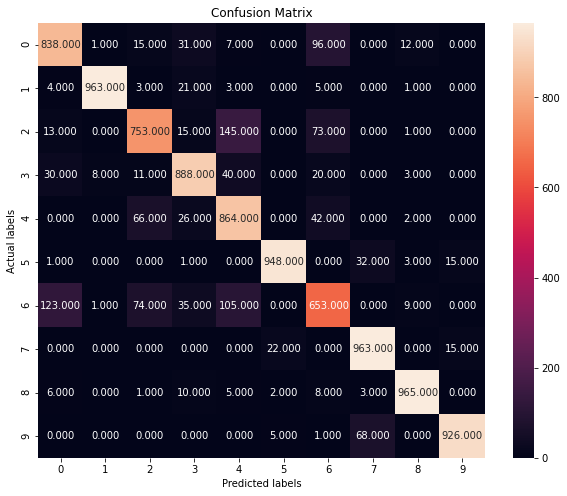

In [ ]:
NN6 = NN(input_shape=784,num_hlayers=1,neurons=[64 ],hiddenLayerActivation='Sigmoid',outputActivation='Softmax',loss='cce',optimizer='nadam',\
           learningrate=0.001,batch_size=16,epochs=20,layerInitialization='Xavier',weightDecay=0,output_shape=10)

pred =MINI_BATCH(NN6,X_actualTrain,Y_actualTrain)
print("train accuracy : ",np.sum(np.argmax(pred,axis=1)==np.argmax(Y_actualTrain,axis=1))/len(Y_actualTrain))

predcv = NN6.Final_Prediction(X_validationData)
print("cv accuracy : ",np.sum(np.argmax(predcv,axis=1)==np.argmax(Y_validationData,axis=1))/len(Y_validationData))

predtest =NN6.Final_Prediction(X_test)
print("TEST accuracy : ",np.sum(np.argmax(predtest,axis=1)==np.argmax(Y_test_ohe,axis=1))/len(Y_test_ohe))

cf6 = confusion_matrix(y_true = np.argmax(Y_test_ohe,axis=1),y_pred = np.argmax(predtest , axis=1))
plot_confusion_mtx(cf6,10)
#wandb.log({"conf_mat" : wandb.plot.confusion_matrix(probs=None,
                        y_true=np.argmax(Y_test_ohe,axis=1), preds=np.argmax(predtest , axis=1),
                        class_names= labels)})

# Question 8 (5 Marks)

In all the models above you would have used cross entropy loss. Now compare the cross entropy loss with the squared error loss. I would again like to see some automatically generated plots or your own plots to convince me whether one is better than the other.

wandb: Currently logged in as: manideepladi (use `wandb login --relogin` to force relogin)


FOR  cce
train accuracy :  0.8961458333333333
train loss :  0.14878335625635794
cv accuracy :  0.8613333333333333
cv loss :  0.20133300563044937
TEST accuracy :  0.8551
Confusion matrix for test :


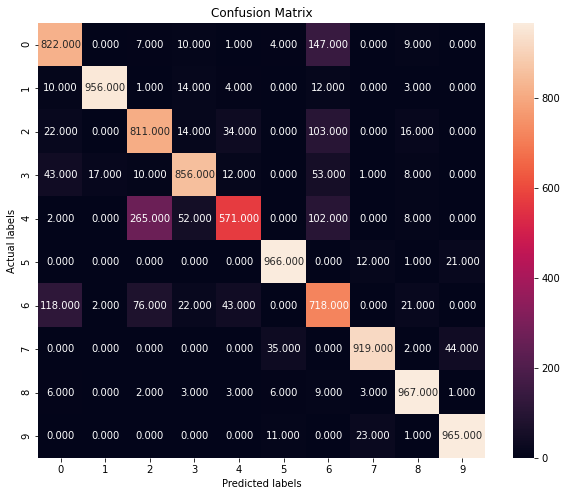

FOR  squarederror
train accuracy :  0.8993541666666667
train loss :  0.15021195869170537
cv accuracy :  0.87575
cv loss :  0.1857301110813917
TEST accuracy :  0.8636
Confusion matrix for test :


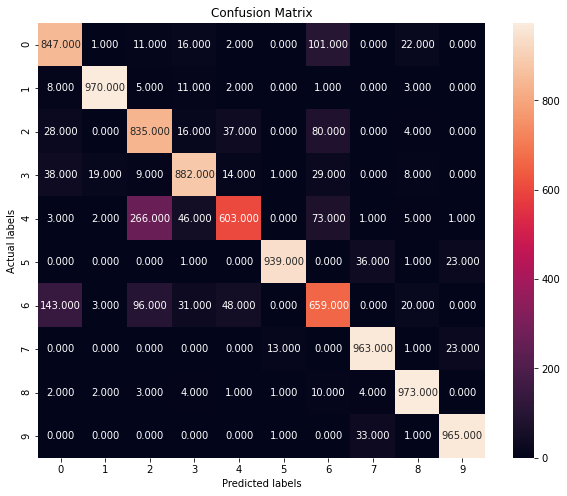

In [ ]:
import wandb
wandb.init(project='DeepLearning', entity='manideepladi')
for loss in ['cce','squarederror']:
  NN1 = NN(input_shape=784,num_hlayers=2,neurons=[64,64],hiddenLayerActivation='ReLU',outputActivation='Softmax',loss=loss,optimizer='nadam',\
            learningrate=0.001,batch_size=16,epochs=20,layerInitialization='Xavier',weightDecay=0.0005,output_shape=10)

  print("FOR ",loss)
  pred =MINI_BATCH(NN1,X_actualTrain,Y_actualTrain)
  print("train accuracy : ",np.sum(np.argmax(pred,axis=1)==np.argmax(Y_actualTrain,axis=1))/len(Y_actualTrain))
  if loss=="squarederror":
    print("train loss : ",np.sum(Loss().MSE(ypred=pred,y=Y_actualTrain)))
  else :
    print("train loss : ",np.sum(Loss().CategoricalCrossEntropy(ypred=pred,y=Y_actualTrain)))

  predcv = NN1.Final_Prediction(X_validationData)
  print("cv accuracy : ",np.sum(np.argmax(predcv,axis=1)==np.argmax(Y_validationData,axis=1))/len(Y_validationData))
  if loss=="squarederror":
    print("cv loss : ",np.sum(Loss().MSE(ypred=predcv,y=Y_validationData)))
  else :
    print("cv loss : ",np.sum(Loss().CategoricalCrossEntropy(ypred=predcv,y=Y_validationData)))
  predtest =NN1.Final_Prediction(X_test)

  predtest =NN1.Final_Prediction(X_test)
  print("TEST accuracy : ",np.sum(np.argmax(predtest,axis=1)==np.argmax(Y_test_ohe,axis=1))/len(Y_test_ohe))
  print("Confusion matrix for test :")
  cf = confusion_matrix(y_true = np.argmax(Y_test_ohe,axis=1),y_pred = np.argmax(predtest , axis=1))
  plot_confusion_mtx(cf,10)
  wandb.log({"conf_mat" : wandb.plot.confusion_matrix(probs=None,
                        y_true=np.argmax(Y_test_ohe,axis=1), preds=np.argmax(predtest , axis=1),
                        class_names= labels)})

_runtime,433
_timestamp,1615827085
_step,1


_runtime,▁█
_timestamp,▁█
_step,▁█


train accuracy :  0.8917083333333333
train loss :  0.16045991991559766
cv accuracy :  0.8641666666666666
cv loss :  0.20489659083028608
TEST accuracy :  0.8565
Confusion matrix for test :


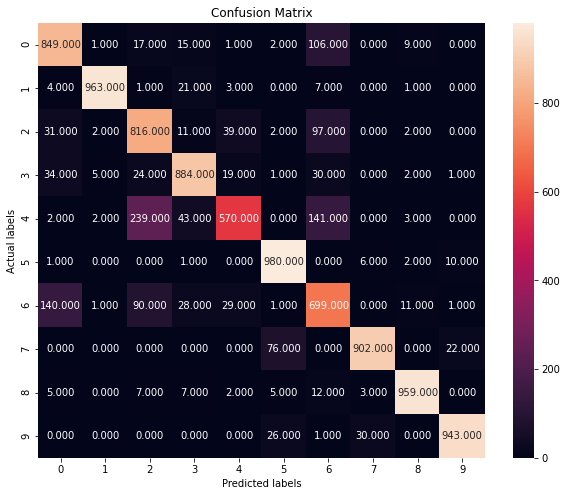

In [ ]:
import wandb
wandb.init(project='DeepLearning', entity='manideepladi')

NN1 = NN(input_shape=784,num_hlayers=2,neurons=[64,64],hiddenLayerActivation='ReLU',outputActivation='Softmax',loss='squarederror',optimizer='nadam',\
            learningrate=0.001,batch_size=16,epochs=20,layerInitialization='Xavier',weightDecay=0.0005,output_shape=10)
pred =MINI_BATCH(NN1,X_actualTrain,Y_actualTrain)
print("train accuracy : ",np.sum(np.argmax(pred,axis=1)==np.argmax(Y_actualTrain,axis=1))/len(Y_actualTrain))
print("train loss : ",np.sum(Loss().MSE(ypred=pred,y=Y_actualTrain)))

predcv = NN1.Final_Prediction(X_validationData)
print("cv accuracy : ",np.sum(np.argmax(predcv,axis=1)==np.argmax(Y_validationData,axis=1))/len(Y_validationData))
print("cv loss : ",np.sum(Loss().MSE(ypred=predcv,y=Y_validationData)))

predtest =NN1.Final_Prediction(X_test)
print("TEST accuracy : ",np.sum(np.argmax(predtest,axis=1)==np.argmax(Y_test_ohe,axis=1))/len(Y_test_ohe))
print("Confusion matrix for test :")
cf = confusion_matrix(y_true = np.argmax(Y_test_ohe,axis=1),y_pred = np.argmax(predtest , axis=1))
plot_confusion_mtx(cf,10)
wandb.log({"conf_mat" : wandb.plot.confusion_matrix(probs=None,
                        y_true=np.argmax(Y_test_ohe,axis=1), preds=np.argmax(predtest , axis=1),
                        class_names= labels)})